In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import reciprocal

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn.feature_selection import SelectKBest, chi2

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
df = pd.read_csv("DataforML.csv", low_memory='False', sep=',')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,C_VEHS,C_CONF1,C_RCFG1,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE1,P_SEX,P_AGE_CAT,P_PSN1,P_ISEV,P_SAFE1,P_USER1,month_sin,month_cos,day_sin,day_cos,time_sin,time_cos
0,2,32,1,1,5,4,18,1,M,6,QQ,1,2,2,0.5,0.866025,0.781831,0.62349,0.136167,-0.990686
1,2,32,1,1,5,4,18,1,F,3,11,0,2,1,0.5,0.866025,0.781831,0.62349,0.136167,-0.990686
2,2,32,1,2,5,3,18,1,F,3,11,0,2,1,0.5,0.866025,0.781831,0.62349,-0.942261,-0.334880
3,2,32,1,2,5,3,18,1,F,1,33,1,2,2,0.5,0.866025,0.781831,0.62349,-0.942261,-0.334880
4,2,32,1,2,5,3,18,1,M,2,11,0,2,1,0.5,0.866025,0.781831,0.62349,-0.942261,-0.334880


In [4]:
df['P_AGE_CAT'] = df['P_AGE_CAT'].astype('category')
df['P_USER1'] = df['P_USER1'].astype('object')
df['P_USER1'] = df['P_USER1'].astype('object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237870 entries, 0 to 237869
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   C_VEHS     237870 non-null  int64   
 1   C_CONF1    237870 non-null  object  
 2   C_RCFG1    237870 non-null  object  
 3   C_WTHR     237870 non-null  object  
 4   C_RSUR     237870 non-null  object  
 5   C_RALN     237870 non-null  object  
 6   C_TRAF     237870 non-null  object  
 7   V_TYPE1    237870 non-null  object  
 8   P_SEX      237870 non-null  object  
 9   P_AGE_CAT  237870 non-null  category
 10  P_PSN1     237870 non-null  object  
 11  P_ISEV     237870 non-null  int64   
 12  P_SAFE1    237870 non-null  object  
 13  P_USER1    237870 non-null  object  
 14  month_sin  237870 non-null  float64 
 15  month_cos  237870 non-null  float64 
 16  day_sin    237870 non-null  float64 
 17  day_cos    237870 non-null  float64 
 18  time_sin   237870 non-null  float64 
 19  ti

In [6]:
Target = 'P_ISEV'
columns_pred = [col for col in df.columns if col not in [Target]]
columns_num = list(df.select_dtypes(include=[np.number]).drop(Target, axis=1).columns)
columns_cat = list(df.select_dtypes(exclude=[np.number]).columns)

### Train Test split

In [7]:
X = df[columns_pred]
y = df[Target]

X.shape, y.shape

((237870, 19), (237870,))

In [8]:
#Stratify split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape)
print("y train shape: ", y_train.shape)
print("y test shape: ", y_test.shape)

X train shape:  (166509, 19)
X test shape:  (71361, 19)
y train shape:  (166509,)
y test shape:  (71361,)


### Pipeline

In [9]:
#Pipeline for categorical features

pipe_cat = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore')),
                    ('select', SelectKBest(score_func=chi2, k=35)),
                    ])

#Pipeline for numerical features

pipe_num = Pipeline([('scaler', StandardScaler()),
                    ])

#Pre-processing pipeline to combine both categorical and numerical features

pipe_preprocessor = ColumnTransformer([('categorical', pipe_cat, columns_cat),
                                      ('numerical', pipe_num, columns_num),
                                      ])

In [10]:
#Transform both train and test data

X_train_transformed = pipe_preprocessor.fit(X_train, y_train).transform(X_train) #SelectKBest uses fit(X,y)

In [11]:
X_test_transformed = pipe_preprocessor.transform(X_test)

In [12]:
X_train_transformed.shape, X_test_transformed.shape

((166509, 42), (71361, 42))

### Sequential model with BatchNormalization, selu activation and Adam optimizer

In [40]:
model1 = keras.models.Sequential()
model1.add(keras.layers.Flatten(input_shape=X_train_transformed.shape[1:]))
for i in range(10):
    model1.add(keras.layers.Dense(30, kernel_initializer='lecun_normal'))
    model1.add(keras.layers.BatchNormalization())
    model1.add(keras.layers.Activation(activation='selu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))


model1.compile(loss=keras.losses.binary_crossentropy, 
              optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), 
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#checkpoint_cb = keras.callbacks.ModelCheckpoint('model_he_adam.h5', save_best_only=True)

hist1 = model1.fit(X_train_transformed, y_train, epochs=100, batch_size=50, validation_split=0.1,
          callbacks=[early_stopping_cb])

Epoch 1/100
2998/2998 [==============================] - 5s 1ms/step - loss: 0.6287 - accuracy: 0.6346 - val_loss: 0.5971 - val_accuracy: 0.6670
Epoch 2/100
2998/2998 [==============================] - 4s 1ms/step - loss: 0.6039 - accuracy: 0.6560 - val_loss: 0.5893 - val_accuracy: 0.6658
Epoch 3/100
2998/2998 [==============================] - 4s 1ms/step - loss: 0.5997 - accuracy: 0.6614 - val_loss: 0.5909 - val_accuracy: 0.6663
Epoch 4/100
2998/2998 [==============================] - 4s 1ms/step - loss: 0.5963 - accuracy: 0.6630 - val_loss: 0.5891 - val_accuracy: 0.6690
Epoch 5/100
2998/2998 [==============================] - 4s 1ms/step - loss: 0.5936 - accuracy: 0.6656 - val_loss: 0.5883 - val_accuracy: 0.6722
Epoch 6/100
2998/2998 [==============================] - 4s 1ms/step - loss: 0.5954 - accuracy: 0.6637 - val_loss: 0.5866 - val_accuracy: 0.6735
Epoch 7/100
2998/2998 [==============================] - 4s 1ms/step - loss: 0.5927 - accuracy: 0.6660 - val_loss: 0.5877 - val_ac

In [41]:
model1.evaluate(X_test_transformed, y_test) 

2231/2231 [==============================] - 1s 361us/step - loss: 0.5886 - accuracy: 0.6674


[0.5886420607566833, 0.6673813462257385]

batchsize change with elu, 20 layers, 28 neurons 
batch size = 50 accuracy on test = 66.9, 
100 accuracy on test = 66.69

selu (super fast) - 10 layers, 30 nodes, batch size=50, adam, accuracy = 67, test - 66.7
20 layers accuracy = almost same as above. keep 10 layers

PReLU - 10 layers, 30 neuron, batch=50, accuracy= 67, test - 66.7
20 layers, 30 neurons, batch=50 acc = 66.6, test - 66.6

keep selu, with BN - 




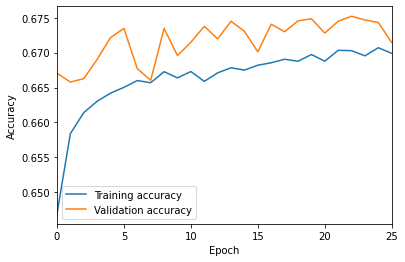

In [42]:
plt.plot(hist1.history['accuracy'], label='Training accuracy')
plt.plot(hist1.history['val_accuracy'], label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.gca().set_xlim(0,25)
plt.show()

In [24]:
#load the best model saved

model_he_adam = keras.models.load_model('model_he_adam.h5')

In [ ]:
model_he_adam.get_config()['layers'][2]['config']['kernel_initializer']['class_name']

## Tuning neural network hyperparameters:
### GridSearchCV using Keras.wrappers

In [43]:
#Funtion to create a simple network with Batch Normalization to search for number of layers, number of nodes and
#batch size with selu activation and Adam optimizer default learning_rate 0.001 and early stopping


def build_model_bn(n_hidden=10, n_neurons=30):
    model_bn = keras.models.Sequential()
    model_bn.add(keras.layers.InputLayer(input_shape=X_train_transformed.shape[1:]))
    for layer in range(n_hidden):
        model_bn.add(keras.layers.Dense(n_neurons, kernel_initializer='lecun_normal'))
        model_bn.add(keras.layers.BatchNormalization())
        model_bn.add(keras.layers.Activation(activation='selu'))
    model_bn.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model_bn.compile(loss=keras.losses.binary_crossentropy, 
              optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), 
              metrics=['accuracy'])
    
    return model_bn

In [44]:
#crate a wrapper to use in GridSearchCV

keras_classif = keras.wrappers.scikit_learn.KerasClassifier(build_model_bn)

In [47]:
#Grid Search

param_grid = {'n_hidden': [5, 10, 15], 'n_neurons': [25, 30], 'batch_size': [20, 32, 50]} 

checkpoint_grid = keras.callbacks.ModelCheckpoint('grid_model.h5', save_best_only=True)
early_stopping_grid = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model1_grid = GridSearchCV(keras_classif, param_grid, cv=3)

t0 = time.time()

model1_g = model1_grid.fit(X_train_transformed, y_train, epochs=100, validation_split=0.1,
          callbacks=[checkpoint_grid, early_stopping_grid] )
t1 = time.time()

print("Search took: {:.2f} mins".format((t1-t0)/60))

Epoch 1/100
4996/4996 [==============================] - 4s 693us/step - loss: 0.6327 - accuracy: 0.6294 - val_loss: 0.5994 - val_accuracy: 0.6644
Epoch 2/100
4996/4996 [==============================] - 3s 672us/step - loss: 0.6068 - accuracy: 0.6565 - val_loss: 0.5943 - val_accuracy: 0.6673
Epoch 3/100
4996/4996 [==============================] - 3s 679us/step - loss: 0.6035 - accuracy: 0.6576 - val_loss: 0.5915 - val_accuracy: 0.6688
Epoch 4/100
4996/4996 [==============================] - 3s 673us/step - loss: 0.5994 - accuracy: 0.6589 - val_loss: 0.5890 - val_accuracy: 0.6685
Epoch 5/100
4996/4996 [==============================] - 3s 670us/step - loss: 0.5993 - accuracy: 0.6561 - val_loss: 0.5880 - val_accuracy: 0.6720
Epoch 6/100
4996/4996 [==============================] - 3s 674us/step - loss: 0.5967 - accuracy: 0.6612 - val_loss: 0.5900 - val_accuracy: 0.6736
Epoch 7/100
4996/4996 [==============================] - 3s 666us/step - loss: 0.5977 - accuracy: 0.6593 - val_loss: 0

Epoch 7/100
4996/4996 [==============================] - 5s 1ms/step - loss: 0.5986 - accuracy: 0.6630 - val_loss: 0.5909 - val_accuracy: 0.6689
Epoch 8/100
4996/4996 [==============================] - 5s 1ms/step - loss: 0.5980 - accuracy: 0.6603 - val_loss: 0.5922 - val_accuracy: 0.6714
Epoch 9/100
4996/4996 [==============================] - 5s 1ms/step - loss: 0.5964 - accuracy: 0.6640 - val_loss: 0.5902 - val_accuracy: 0.6710
Epoch 10/100
4996/4996 [==============================] - 5s 1ms/step - loss: 0.5972 - accuracy: 0.6638 - val_loss: 0.5910 - val_accuracy: 0.6662
Epoch 11/100
4996/4996 [==============================] - 5s 1ms/step - loss: 0.5969 - accuracy: 0.6590 - val_loss: 0.5909 - val_accuracy: 0.6726
Epoch 12/100
4996/4996 [==============================] - 5s 1ms/step - loss: 0.5953 - accuracy: 0.6645 - val_loss: 0.5878 - val_accuracy: 0.6736
Epoch 13/100
4996/4996 [==============================] - 5s 1ms/step - loss: 0.5953 - accuracy: 0.6648 - val_loss: 0.5870 - va

4996/4996 [==============================] - 7s 1ms/step - loss: 0.6112 - accuracy: 0.6507 - val_loss: 0.5955 - val_accuracy: 0.6667
Epoch 4/100
4996/4996 [==============================] - 7s 1ms/step - loss: 0.6081 - accuracy: 0.6552 - val_loss: 0.5913 - val_accuracy: 0.6679
Epoch 5/100
4996/4996 [==============================] - 7s 1ms/step - loss: 0.6054 - accuracy: 0.6571 - val_loss: 0.5964 - val_accuracy: 0.6679
Epoch 6/100
4996/4996 [==============================] - 7s 1ms/step - loss: 0.6020 - accuracy: 0.6603 - val_loss: 0.6061 - val_accuracy: 0.6701
Epoch 7/100
4996/4996 [==============================] - 7s 1ms/step - loss: 0.6008 - accuracy: 0.6599 - val_loss: 0.5945 - val_accuracy: 0.6666
Epoch 8/100
4996/4996 [==============================] - 7s 1ms/step - loss: 0.6021 - accuracy: 0.6595 - val_loss: 0.5886 - val_accuracy: 0.6732
Epoch 9/100
4996/4996 [==============================] - 7s 1ms/step - loss: 0.5983 - accuracy: 0.6630 - val_loss: 0.5898 - val_accuracy: 0.66

Epoch 4/100
3123/3123 [==============================] - 2s 714us/step - loss: 0.5985 - accuracy: 0.6592 - val_loss: 0.5876 - val_accuracy: 0.6681
Epoch 5/100
3123/3123 [==============================] - 2s 712us/step - loss: 0.5959 - accuracy: 0.6617 - val_loss: 0.5877 - val_accuracy: 0.6703
Epoch 6/100
3123/3123 [==============================] - 2s 711us/step - loss: 0.5966 - accuracy: 0.6620 - val_loss: 0.5893 - val_accuracy: 0.6688
Epoch 7/100
3123/3123 [==============================] - 2s 711us/step - loss: 0.5970 - accuracy: 0.6629 - val_loss: 0.5854 - val_accuracy: 0.6674
Epoch 8/100
3123/3123 [==============================] - 2s 709us/step - loss: 0.5928 - accuracy: 0.6626 - val_loss: 0.5873 - val_accuracy: 0.6719
Epoch 9/100
3123/3123 [==============================] - 2s 718us/step - loss: 0.5933 - accuracy: 0.6638 - val_loss: 0.5854 - val_accuracy: 0.6688
Epoch 10/100
3123/3123 [==============================] - 2s 712us/step - loss: 0.5936 - accuracy: 0.6632 - val_loss: 

Epoch 11/100
3123/3123 [==============================] - 2s 747us/step - loss: 0.5916 - accuracy: 0.6666 - val_loss: 0.5886 - val_accuracy: 0.6689
Epoch 12/100
1735/1735 [==============================] - 0s 274us/step - loss: 0.5933 - accuracy: 0.6677
Epoch 1/100
3123/3123 [==============================] - 3s 791us/step - loss: 0.6289 - accuracy: 0.6324 - val_loss: 0.5985 - val_accuracy: 0.6635
Epoch 2/100
3123/3123 [==============================] - 3s 806us/step - loss: 0.6057 - accuracy: 0.6545 - val_loss: 0.5912 - val_accuracy: 0.6647
Epoch 3/100
3123/3123 [==============================] - 3s 846us/step - loss: 0.6006 - accuracy: 0.6589 - val_loss: 0.5893 - val_accuracy: 0.6696
Epoch 4/100
3123/3123 [==============================] - 2s 763us/step - loss: 0.5966 - accuracy: 0.6616 - val_loss: 0.5892 - val_accuracy: 0.6695
Epoch 5/100
3123/3123 [==============================] - 2s 772us/step - loss: 0.5962 - accuracy: 0.6623 - val_loss: 0.5894 - val_accuracy: 0.6685
Epoch 6/100

1735/1735 [==============================] - 1s 345us/step - loss: 0.5873 - accuracy: 0.6710
Epoch 1/100
3123/3123 [==============================] - 5s 1ms/step - loss: 0.6376 - accuracy: 0.6251 - val_loss: 0.6066 - val_accuracy: 0.6566
Epoch 2/100
3123/3123 [==============================] - 4s 1ms/step - loss: 0.6079 - accuracy: 0.6533 - val_loss: 0.5965 - val_accuracy: 0.6660
Epoch 3/100
3123/3123 [==============================] - 4s 1ms/step - loss: 0.6027 - accuracy: 0.6601 - val_loss: 0.5906 - val_accuracy: 0.6683
Epoch 4/100
3123/3123 [==============================] - 4s 1ms/step - loss: 0.6009 - accuracy: 0.6590 - val_loss: 0.5896 - val_accuracy: 0.6704
Epoch 5/100
3123/3123 [==============================] - 4s 1ms/step - loss: 0.5991 - accuracy: 0.6609 - val_loss: 0.5875 - val_accuracy: 0.6667
Epoch 6/100
3123/3123 [==============================] - 4s 1ms/step - loss: 0.5955 - accuracy: 0.6642 - val_loss: 0.5903 - val_accuracy: 0.6648
Epoch 7/100
3123/3123 [==============

Epoch 4/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.6023 - accuracy: 0.6590 - val_loss: 0.5942 - val_accuracy: 0.6695
Epoch 5/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.6021 - accuracy: 0.6573 - val_loss: 0.5933 - val_accuracy: 0.6729
Epoch 6/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.6019 - accuracy: 0.6578 - val_loss: 0.5876 - val_accuracy: 0.6721
Epoch 7/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5976 - accuracy: 0.6632 - val_loss: 0.5881 - val_accuracy: 0.6683
Epoch 8/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5954 - accuracy: 0.6618 - val_loss: 0.5887 - val_accuracy: 0.6718
Epoch 9/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5946 - accuracy: 0.6648 - val_loss: 0.5896 - val_accuracy: 0.6671
Epoch 10/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5961 - accuracy: 0.6631 - val_loss: 0.5869 - val_a

3123/3123 [==============================] - 5s 2ms/step - loss: 0.5892 - accuracy: 0.6710 - val_loss: 0.5931 - val_accuracy: 0.6640
Epoch 26/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5906 - accuracy: 0.6667 - val_loss: 0.5937 - val_accuracy: 0.6635
Epoch 27/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5890 - accuracy: 0.6691 - val_loss: 0.5929 - val_accuracy: 0.6658
Epoch 28/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5910 - accuracy: 0.6670 - val_loss: 0.5933 - val_accuracy: 0.6662
Epoch 29/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5913 - accuracy: 0.6683 - val_loss: 0.5939 - val_accuracy: 0.6675
Epoch 30/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5894 - accuracy: 0.6679 - val_loss: 0.5972 - val_accuracy: 0.6670
Epoch 31/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.5907 - accuracy: 0.6695 - val_loss: 0.5961 - val_accuracy

Epoch 13/100
1999/1999 [==============================] - 1s 742us/step - loss: 0.5903 - accuracy: 0.6647 - val_loss: 0.5925 - val_accuracy: 0.6657
Epoch 14/100
1999/1999 [==============================] - 1s 728us/step - loss: 0.5918 - accuracy: 0.6645 - val_loss: 0.5926 - val_accuracy: 0.6677
Epoch 15/100
1999/1999 [==============================] - 1s 728us/step - loss: 0.5905 - accuracy: 0.6657 - val_loss: 0.5936 - val_accuracy: 0.6652
Epoch 16/100
1999/1999 [==============================] - 1s 742us/step - loss: 0.5893 - accuracy: 0.6697 - val_loss: 0.5923 - val_accuracy: 0.6662
Epoch 17/100
1999/1999 [==============================] - 1s 731us/step - loss: 0.5896 - accuracy: 0.6673 - val_loss: 0.5914 - val_accuracy: 0.6673
Epoch 18/100
1999/1999 [==============================] - 1s 728us/step - loss: 0.5894 - accuracy: 0.6706 - val_loss: 0.5929 - val_accuracy: 0.6657
Epoch 19/100
1999/1999 [==============================] - 1s 739us/step - loss: 0.5919 - accuracy: 0.6658 - val_

1999/1999 [==============================] - 2s 1ms/step - loss: 0.5929 - accuracy: 0.6656 - val_loss: 0.5862 - val_accuracy: 0.6721
Epoch 10/100
1999/1999 [==============================] - 2s 1ms/step - loss: 0.5920 - accuracy: 0.6671 - val_loss: 0.5841 - val_accuracy: 0.6745
Epoch 11/100
1999/1999 [==============================] - 2s 1ms/step - loss: 0.5919 - accuracy: 0.6669 - val_loss: 0.5832 - val_accuracy: 0.6744
Epoch 12/100
1999/1999 [==============================] - 2s 1ms/step - loss: 0.5923 - accuracy: 0.6667 - val_loss: 0.5833 - val_accuracy: 0.6718
Epoch 13/100
1999/1999 [==============================] - 2s 1ms/step - loss: 0.5904 - accuracy: 0.6702 - val_loss: 0.5855 - val_accuracy: 0.6755
Epoch 14/100
1999/1999 [==============================] - 2s 1ms/step - loss: 0.5902 - accuracy: 0.6672 - val_loss: 0.5874 - val_accuracy: 0.6688
Epoch 15/100
1999/1999 [==============================] - 2s 1ms/step - loss: 0.5901 - accuracy: 0.6677 - val_loss: 0.5849 - val_accuracy

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5916 - accuracy: 0.6651 - val_loss: 0.5895 - val_accuracy: 0.6726
Epoch 18/100
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5906 - accuracy: 0.6664 - val_loss: 0.5854 - val_accuracy: 0.6735
Epoch 19/100
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5886 - accuracy: 0.6690 - val_loss: 0.5846 - val_accuracy: 0.6741
Epoch 20/100
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5897 - accuracy: 0.6662 - val_loss: 0.5855 - val_accuracy: 0.6724
Epoch 21/100
1111/1111 [==============================] - 1s 462us/step - loss: 0.5891 - accuracy: 0.6699
Epoch 1/100
1999/1999 [==============================] - 5s 2ms/step - loss: 0.6394 - accuracy: 0.6265 - val_loss: 0.5980 - val_accuracy: 0.6617
Epoch 2/100
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6064 - accuracy: 0.6562 - val_loss: 0.5939 - val_accuracy: 0.6671
Epoch 3/100
1999/1999 [==========

4684/4684 [==============================] - 7s 1ms/step - loss: 0.6303 - accuracy: 0.6323 - val_loss: 0.5990 - val_accuracy: 0.6633
Epoch 2/100
4684/4684 [==============================] - 6s 1ms/step - loss: 0.6079 - accuracy: 0.6547 - val_loss: 0.6002 - val_accuracy: 0.6568
Epoch 3/100
4684/4684 [==============================] - 6s 1ms/step - loss: 0.6027 - accuracy: 0.6578 - val_loss: 0.5920 - val_accuracy: 0.6694
Epoch 4/100
4684/4684 [==============================] - 6s 1ms/step - loss: 0.6011 - accuracy: 0.6593 - val_loss: 0.5956 - val_accuracy: 0.6653
Epoch 5/100
4684/4684 [==============================] - 6s 1ms/step - loss: 0.5976 - accuracy: 0.6633 - val_loss: 0.5881 - val_accuracy: 0.6709
Epoch 6/100
4684/4684 [==============================] - 6s 1ms/step - loss: 0.5964 - accuracy: 0.6631 - val_loss: 0.5887 - val_accuracy: 0.6723
Epoch 7/100
4684/4684 [==============================] - 6s 1ms/step - loss: 0.5951 - accuracy: 0.6620 - val_loss: 0.5898 - val_accuracy: 0.67

In [ ]:
#grid_search_model = keras.models.load_model("grid_model.h5")

In [48]:
model1_g.best_params_

{'batch_size': 32, 'n_hidden': 10, 'n_neurons': 30}

In [53]:
for mean, params in sorted(zip(model1_g.cv_results_['mean_test_score'], model1_g.cv_results_['params'])):
    print("%f with: %r" %(mean, params))

0.667315 with: {'batch_size': 20, 'n_hidden': 15, 'n_neurons': 30}
0.667784 with: {'batch_size': 20, 'n_hidden': 5, 'n_neurons': 30}
0.667814 with: {'batch_size': 50, 'n_hidden': 15, 'n_neurons': 30}
0.668006 with: {'batch_size': 20, 'n_hidden': 10, 'n_neurons': 25}
0.668030 with: {'batch_size': 50, 'n_hidden': 5, 'n_neurons': 25}
0.668048 with: {'batch_size': 20, 'n_hidden': 10, 'n_neurons': 30}
0.668192 with: {'batch_size': 50, 'n_hidden': 15, 'n_neurons': 25}
0.668270 with: {'batch_size': 32, 'n_hidden': 15, 'n_neurons': 25}
0.668324 with: {'batch_size': 20, 'n_hidden': 15, 'n_neurons': 25}
0.668588 with: {'batch_size': 20, 'n_hidden': 5, 'n_neurons': 25}
0.668703 with: {'batch_size': 50, 'n_hidden': 10, 'n_neurons': 25}
0.668823 with: {'batch_size': 32, 'n_hidden': 5, 'n_neurons': 30}
0.668871 with: {'batch_size': 32, 'n_hidden': 5, 'n_neurons': 25}
0.669093 with: {'batch_size': 50, 'n_hidden': 5, 'n_neurons': 30}
0.669129 with: {'batch_size': 32, 'n_hidden': 10, 'n_neurons': 25}
0

best: batch size=32, layers=10, nodes=30, acc=66.929
2nd best: batch size=32 layers=15, nodes=30, acc=66.922
3rd best: batch_size=32, layers=10, nodes=30, acc=66.919

Use Kera Tuner to tune with batch_size between 32 and 50,
layers between 10 to 25
number of neurons between 25 to 40
activation selu with lecun initilization


In [57]:
model_grid = keras.models.load_model("grid_model.h5") #model1_g.best_estimator_

In [58]:
model_grid.evaluate(X_test_transformed, y_test)

2231/2231 [==============================] - 1s 274us/step - loss: 0.5895 - accuracy: 0.6675


[0.5895346403121948, 0.667493462562561]

### Keras Tuner

In [62]:
from keras_tuner.tuners import RandomSearch


In [101]:
def build_model_tuner(hp):
    model_kt = keras.models.Sequential()
    model_kt.add(keras.layers.InputLayer(input_shape=X_train_transformed.shape[1:]))
    for layer in range(hp.Int('n_layers',10, 20, step=1)):
        model_kt.add(keras.layers.Dense(units=hp.Int('units', min_value=30, max_value=50, step=2),
                    kernel_initializer='lecun_normal'))
        model_kt.add(keras.layers.BatchNormalization())
        model_kt.add(keras.layers.Activation(activation='selu'))
    model_kt.add(keras.layers.Dense(1, activation='sigmoid'))
    
    lr = hp.Float("lr", min_value=1e-3 , max_value=0.1)
    model_kt.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr), 
                                                                                 metrics=['accuracy'])
    
    return model_kt
        

In [102]:
tuner = RandomSearch(build_model_tuner,
                    objective = 'val_accuracy',
                    max_trials = 25,
                    executions_per_trial=1,
                    directory='NationalCollisionLogs',
                    project_name='Tuner1')

In [103]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 20, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 50, 'step': 2, 'sampling': None}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': None}


In [104]:
#checkpoint_tuner = keras.callbacks.ModelCheckpoint('tuner_model.h5', save_best_only=True)

#early_stopping_grid = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

t0 = time.time()
tuner.search(X_train_transformed, y_train, epochs=100, validation_split=0.1,
            callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])
t1 = time.time()

print("Search took: {:.2f} mins".format((t1-t0)/60))

Trial 25 Complete [00h 01m 21s]
val_accuracy: 0.6728124618530273

Best val_accuracy So Far: 0.6760554909706116
Total elapsed time: 00h 44m 15s
INFO:tensorflow:Oracle triggered exit
Search took: 44.24 mins


In [105]:
tuner.results_summary()

Results summary
Results in NationalCollisionLogs/Tuner1
Showing 10 best trials
Trial summary
Hyperparameters:
n_layers: 20
units: 36
lr: 0.0020354191041813225
Score: 0.6760554909706116
Trial summary
Hyperparameters:
n_layers: 14
units: 34
lr: 0.023602130543966933
Score: 0.6746742129325867
Trial summary
Hyperparameters:
n_layers: 17
units: 46
lr: 0.012460713342286982
Score: 0.6737132668495178
Trial summary
Hyperparameters:
n_layers: 18
units: 32
lr: 0.06331652671566725
Score: 0.6733529567718506
Trial summary
Hyperparameters:
n_layers: 13
units: 34
lr: 0.06858887662678276
Score: 0.6733529567718506
Trial summary
Hyperparameters:
n_layers: 19
units: 44
lr: 0.02224472975661917
Score: 0.6728724837303162
Trial summary
Hyperparameters:
n_layers: 19
units: 34
lr: 0.027989401818685665
Score: 0.6728124618530273
Trial summary
Hyperparameters:
n_layers: 12
units: 30
lr: 0.050812678446296125
Score: 0.6728124618530273
Trial summary
Hyperparameters:
n_layers: 13
units: 48
lr: 0.04532173576000593
Score

In [112]:
#best hyperparameteer/model values
print(tuner.get_best_hyperparameters()[0].values)
print(tuner.get_best_models()[0].summary())

{'n_layers': 20, 'units': 36, 'lr': 0.0020354191041813225}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                1548      
_________________________________________________________________
batch_normalization (BatchNo (None, 36)                144       
_________________________________________________________________
activation (Activation)      (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                1332      
_________________________________________________________________
batch_normalization_1 (Batch (None, 36)                144       
_________________________________________________________________
activation_1 (Activation)    (None, 36)                0         
_______________________________________________________________

None


In [125]:
print(tuner.get_best_hyperparameters(2)[0].values)
#best_hps

{'n_layers': 20, 'units': 36, 'lr': 0.0020354191041813225}


In [131]:
#Get the best hyperparameters and train the model on the full training set

best_hps = tuner.get_best_hyperparameters(2)
best_model = build_model_tuner(best_hps[0])

best_model.fit(X_train_transformed, y_train, epochs=30)

Epoch 1/30
5204/5204 [==============================] - 12s 2ms/step - loss: 0.6346 - accuracy: 0.6307
Epoch 2/30
5204/5204 [==============================] - 11s 2ms/step - loss: 0.6097 - accuracy: 0.6517
Epoch 3/30
5204/5204 [==============================] - 11s 2ms/step - loss: 0.6054 - accuracy: 0.6549
Epoch 4/30
5204/5204 [==============================] - 11s 2ms/step - loss: 0.6038 - accuracy: 0.6553
Epoch 5/30
5204/5204 [==============================] - 11s 2ms/step - loss: 0.6028 - accuracy: 0.6584
Epoch 6/30
5204/5204 [==============================] - 11s 2ms/step - loss: 0.5987 - accuracy: 0.6626
Epoch 7/30
5204/5204 [==============================] - 11s 2ms/step - loss: 0.6004 - accuracy: 0.6615
Epoch 8/30
5204/5204 [==============================] - 11s 2ms/step - loss: 0.5984 - accuracy: 0.6613
Epoch 9/30
5204/5204 [==============================] - 11s 2ms/step - loss: 0.5960 - accuracy: 0.6640
Epoch 10/30
5204/5204 [==============================] - 11s 2ms/step - l

In [170]:
#save the best neural network model

best_model.save("nn_model.h5")

In [13]:
nn_model = keras.models.load_model('nn_model.h5')

In [14]:
#evaluate on the test set

nn_model.evaluate(X_test_transformed, y_test)

2231/2231 [==============================] - 1s 526us/step - loss: 0.5907 - accuracy: 0.6674


[0.590666651725769, 0.6673673391342163]

## Learning Rate Scheduling
### Performance scheduling using ReduceLROnPlateau callback

In [151]:
model2 = keras.models.Sequential()
model2.add(keras.layers.InputLayer(input_shape=X_train_transformed.shape[1:]))
for i in range(20):
    model2.add(keras.layers.Dense(36, kernel_initializer='lecun_normal'))
    model2.add(keras.layers.BatchNormalization())
    model2.add(keras.layers.Activation(activation='selu'))
    
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.1),
              metrics=['accuracy'])

callback_lr = keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, verbose=2)

hist_reduce_lr = model2.fit(X_train_transformed, y_train, epochs=100, validation_split=0.1,
          callbacks=[callback_lr])

Epoch 1/100
4684/4684 [==============================] - 12s 2ms/step - loss: 0.6452 - accuracy: 0.6188 - val_loss: 0.6021 - val_accuracy: 0.6607
Epoch 2/100
4684/4684 [==============================] - 10s 2ms/step - loss: 0.6246 - accuracy: 0.6402 - val_loss: 0.7475 - val_accuracy: 0.6152
Epoch 3/100
4684/4684 [==============================] - 10s 2ms/step - loss: 0.6225 - accuracy: 0.6445 - val_loss: 0.6222 - val_accuracy: 0.6135
Epoch 4/100
4684/4684 [==============================] - 10s 2ms/step - loss: 0.6175 - accuracy: 0.6454 - val_loss: 0.6979 - val_accuracy: 0.5834
Epoch 5/100
4684/4684 [==============================] - 10s 2ms/step - loss: 0.6248 - accuracy: 0.6447 - val_loss: 0.6456 - val_accuracy: 0.5789
Epoch 6/100
4684/4684 [==============================] - 10s 2ms/step - loss: 0.6201 - accuracy: 0.6468 - val_loss: 0.6480 - val_accuracy: 0.6018

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.020000000298023225.
Epoch 7/100
4684/4684 [=====================


Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.559999757067999e-07.
Epoch 53/100
4684/4684 [==============================] - 10s 2ms/step - loss: 0.5923 - accuracy: 0.6670 - val_loss: 0.5867 - val_accuracy: 0.6746
Epoch 54/100
4684/4684 [==============================] - 10s 2ms/step - loss: 0.5871 - accuracy: 0.6705 - val_loss: 0.5852 - val_accuracy: 0.6750
Epoch 55/100
4684/4684 [==============================] - 10s 2ms/step - loss: 0.5908 - accuracy: 0.6692 - val_loss: 0.5874 - val_accuracy: 0.6749
Epoch 56/100
4684/4684 [==============================] - 9s 2ms/step - loss: 0.5890 - accuracy: 0.6689 - val_loss: 0.5841 - val_accuracy: 0.6750
Epoch 57/100
4684/4684 [==============================] - 9s 2ms/step - loss: 0.5893 - accuracy: 0.6702 - val_loss: 0.5899 - val_accuracy: 0.6725
Epoch 58/100
4684/4684 [==============================] - 10s 2ms/step - loss: 0.5907 - accuracy: 0.6701 - val_loss: 0.5870 - val_accuracy: 0.6747
Epoch 59/100
4684/4684 [===============

In [152]:
model2.evaluate(X_test_transformed, y_test)

2231/2231 [==============================] - 1s 536us/step - loss: 0.5904 - accuracy: 0.6663


[0.5904138684272766, 0.6663163304328918]

Draw roc_auc_curve for the previous model

In [15]:
#roc score for train and test data

y_train_kpred = nn_model.predict(X_train_transformed).ravel()
fpr_train_nn, tpr_train_nn, ths_train_nn = roc_curve(y_train, y_train_kpred)
keras_train_roc_auc = roc_auc_score(y_train, y_train_kpred)


y_test_kpred = nn_model.predict(X_test_transformed).ravel()
fpr_test_nn, tpr_test_nn, ths_test_nn = roc_curve(y_test, y_test_kpred)
keras_test_roc_auc = roc_auc_score(y_test, y_test_kpred)

keras_train_roc_auc, keras_test_roc_auc

(0.7340212576720065, 0.7273667387023048)

In [17]:
#save the variables required for ROC curves

np.save('fpr_train_nn.npy', fpr_train_nn)
np.save('tpr_train_nn.npy', tpr_train_nn)
np.save('fpr_test_nn.npy', fpr_test_nn)
np.save('tpr_test_nn.npy', tpr_test_nn)